<a href="https://colab.research.google.com/github/gtnothaft/Steane_pauli_error/blob/main/Steane_under_Pauli_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install qiskit qiskit_aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=208040aee68896f4670bed1f34e9f3e8f971ab66e3183dc8c88f7b55e9f34235
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


the logical qubits were defined on sloanes paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.77.793

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# 1. Define the parity-check matrix H (based on Nielsen & Chuang section 10.4.2)


def matrix():
  H = np.array([
    [0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]
  ])
  return H

def zero_state():
  H=matrix()

  # 2. Compute dual codewords C^⊥ (X-stabilizers)
  dual_codewords = []
  for coeffs in np.ndindex(*([2]*3)):  # All 3-bit combinations
    codeword = np.mod(np.dot(coeffs, H), 2)
    dual_codewords.append(''.join(map(str, codeword)))

  # 3. Create |0_L⟩ statevector
  zero_L = np.zeros(2**7)
  for c in dual_codewords:
    zero_L[int(c, 2)] = 1/np.sqrt(8)

  # 4. Create quantum circuit and inject state
  qc = QuantumCircuit(7)
  qc.initialize(Statevector(zero_L), range(7))
  return qc

def one_state():
  qc= zero_state()
  qc.barrier()
  for i in range(7):
    qc.x(i)
  return qc


qc = zero_state()
# 5. Verify and visualize
sv = Statevector(qc)
print("Logical |0_L⟩ state (non-zero amplitudes):")
for i, amp in enumerate(sv):
    if not np.isclose(amp, 0):
        print(f"|{format(i, '07b')}⟩ : {amp:.4f}")

qc1 = one_state()

sv = Statevector(qc1)
print("Logical |1_L⟩ state (non-zero amplitudes):")
for i, amp in enumerate(sv):
    if not np.isclose(amp, 0):
        print(f"|{format(i, '07b')}⟩ : {amp:.4f}")

#qc1.draw('mpl')

Logical |0_L⟩ state (non-zero amplitudes):
|0000000⟩ : 0.3536+0.0000j
|0001111⟩ : 0.3536+0.0000j
|0110011⟩ : 0.3536+0.0000j
|0111100⟩ : 0.3536+0.0000j
|1010101⟩ : 0.3536+0.0000j
|1011010⟩ : 0.3536+0.0000j
|1100110⟩ : 0.3536+0.0000j
|1101001⟩ : 0.3536+0.0000j
Logical |1_L⟩ state (non-zero amplitudes):
|0010110⟩ : 0.3536+0.0000j
|0011001⟩ : 0.3536+0.0000j
|0100101⟩ : 0.3536+0.0000j
|0101010⟩ : 0.3536+0.0000j
|1000011⟩ : 0.3536+0.0000j
|1001100⟩ : 0.3536+0.0000j
|1110000⟩ : 0.3536+0.0000j
|1111111⟩ : 0.3536+0.0000j


|0_L⟩:


<IPython.core.display.Latex object>

|1_L⟩:


<IPython.core.display.Latex object>

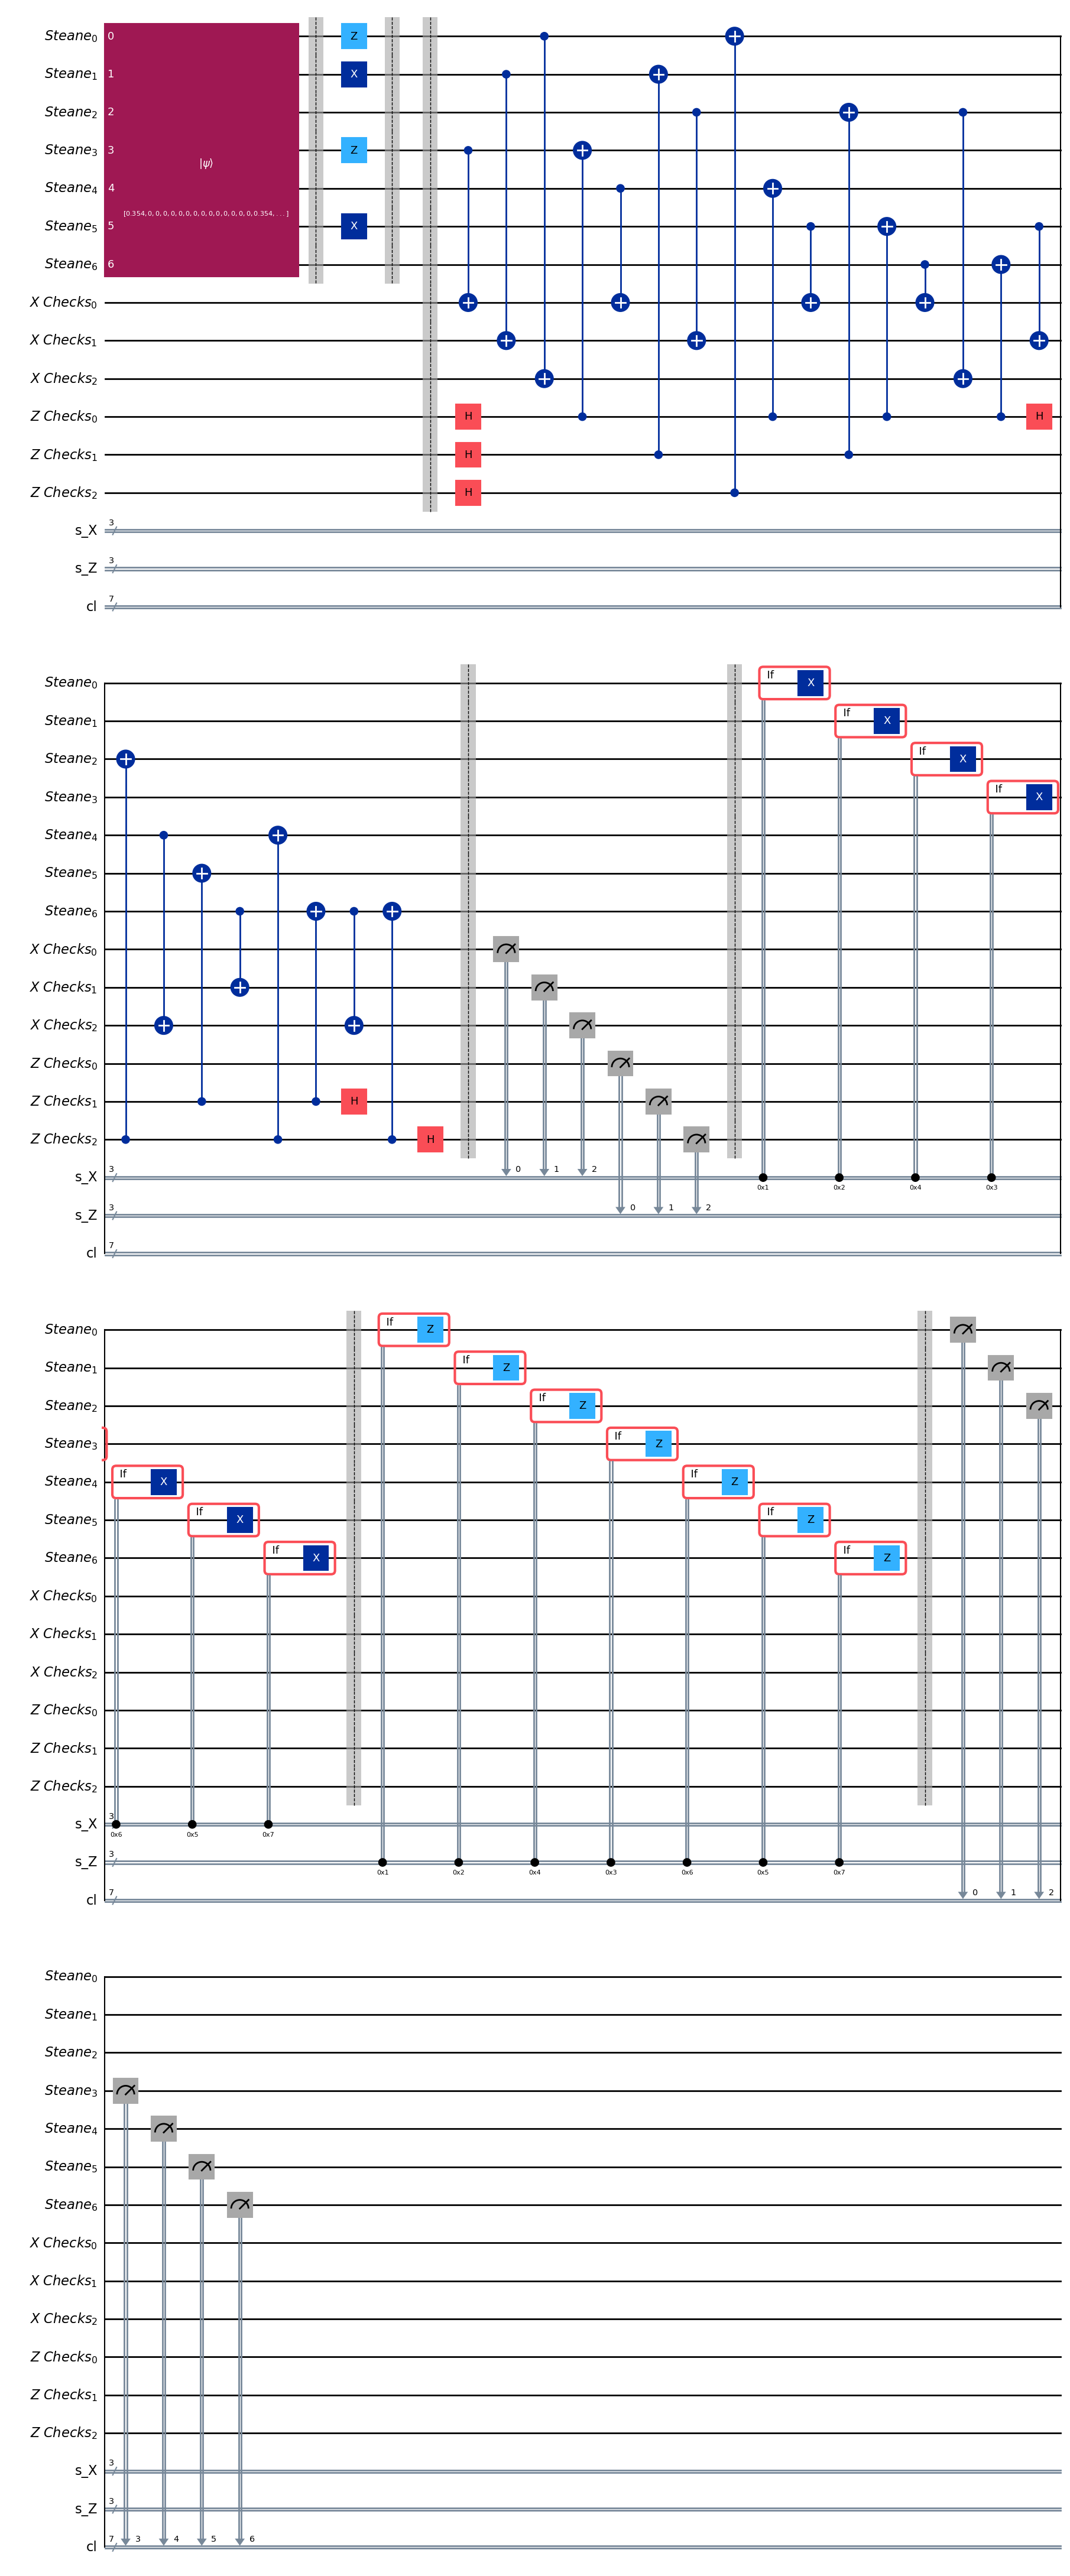

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile

# Define the basis states for |0_L⟩ and |1_L⟩
def matrix():
  H = np.array([
    [0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]
  ])
  return H

def zero_state():
  H=matrix()

  # 2. Compute dual codewords C^⊥ (X-stabilizers)
  dual_codewords = []
  for coeffs in np.ndindex(*([2]*3)):  # All 3-bit combinations
    codeword = np.mod(np.dot(coeffs, H), 2)
    dual_codewords.append(''.join(map(str, codeword)))

  # 3. Create |0_L⟩ statevector
  zero_L = np.zeros(2**7)
  for c in dual_codewords:
    zero_L[int(c, 2)] = 1 / np.sqrt(8)

  # 4. Create quantum circuit and inject state
  steane=QuantumRegister(7, "Steane")
  qc = QuantumCircuit(steane)
  qc.initialize(Statevector(zero_L), range(7))
  return qc, steane

def one_state():
  qc,steane= zero_state()
  for i in range(7):
    qc.x(steane[i])
  return qc,steane

def prepare_logical_state(x: int):
    """Prepares |x_L⟩ on a 7-qubit circuit."""
    if x==0:
      qc,steane = zero_state()
    else:
      qc,steane = one_state()
    return qc,steane

def apply_error(qc, qubits, p):
    for qubit in qubits:
        if np.random.random() < p:
            error_type = np.random.choice(['x', 'z'])
            if error_type == 'x':
                qc.x(qubit)
            elif error_type == 'z':
                qc.z(qubit)
    return qc

def pauli_error_channel(x,p):
  qc,steane=prepare_logical_state(x)
  qc.barrier()

  apply_error(qc, steane, p)
  qc.barrier()


  #add ancillas
  x_check = AncillaRegister(3, "X Checks")
  z_check = AncillaRegister(3, "Z Checks")
  qc.add_register(x_check, z_check)
  qc.barrier()
  #extract syndromes
  for idx, row in enumerate(matrix()):
    qc.h(z_check[idx])
    for qubit in np.where(row)[0]:
        qc.cx(qubit, x_check[idx]) # X check
        qc.cx(z_check[idx], qubit) # Z check
    qc.h(z_check[idx])

  qc.barrier()

  #classical bits
  X_syndromes = ClassicalRegister(3, name="s_X")
  Z_syndromes = ClassicalRegister(3, name="s_Z")
  qc.add_register(X_syndromes, Z_syndromes)

  #measure
  qc.measure(x_check, X_syndromes)
  qc.measure(z_check, Z_syndromes)

  qc.barrier()

  return qc, X_syndromes, Z_syndromes, steane

def checks(qc, X_syndromes, Z_syndromes,steane):
  with qc.if_test((X_syndromes, 1)):
    qc.x(steane[0])

  with qc.if_test((X_syndromes, 2)):
    qc.x(steane[1])

  with qc.if_test((X_syndromes, 4)):
    qc.x(steane[2])

  with qc.if_test((X_syndromes, 3)):
    qc.x(steane[3])

  with qc.if_test((X_syndromes, 6)):
    qc.x(steane[4])

  with qc.if_test((X_syndromes, 5)):
    qc.x(steane[5])

  with qc.if_test((X_syndromes, 7)):
    qc.x(steane[6])

  qc.barrier()

  with qc.if_test((Z_syndromes, 1)):
    qc.z(steane[0])

  with qc.if_test((Z_syndromes, 2)):
    qc.z(steane[1])

  with qc.if_test((Z_syndromes, 4)):
    qc.z(steane[2])

  with qc.if_test((Z_syndromes, 3)):
    qc.z(steane[3])

  with qc.if_test((Z_syndromes, 6)):
    qc.z(steane[4])

  with qc.if_test((Z_syndromes, 5)):
    qc.z(steane[5])

  with qc.if_test((Z_syndromes, 7)):
    qc.z(steane[6])

  qc.barrier()

  return qc, steane
q1,trash= prepare_logical_state(1)
q0,trash2 = prepare_logical_state(0)
print("|0_L⟩:")
display(Statevector(q0).draw('latex'))  # Shows superposition of zero_L_basis states

print("|1_L⟩:")
display(Statevector(q1).draw('latex'))  # Shows superposition of one_L_basis states


p=.5
x=0
qc, X_syndromes, Z_syndromes,steane = pauli_error_channel(x,p)

qcf,steane=checks(qc, X_syndromes, Z_syndromes,steane)

qubit_measurements = ClassicalRegister(7, name=f"cl")
qcf.add_register(qubit_measurements)

# measure
qcf.measure(steane, qubit_measurements)


qcf.draw(output="mpl")


add checks

In [ ]:
# @title
simulator = AerSimulator()

rounds = 200
# Transpile the circuit for the backend
compiled_circuit = transpile(qcf, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution

{'0001110': 0.07,
 '1000101': 0.07,
 '1001011': 0.05,
 '1010101': 0.05499999999999999,
 '0011110': 0.07500000000000001,
 '1110110': 0.055,
 '1011011': 0.08,
 '0010000': 0.05500000000000001,
 '0101101': 0.075,
 '1111000': 0.055,
 '0100011': 0.07500000000000001,
 '1100110': 0.075,
 '1101000': 0.05,
 '0111101': 0.06,
 '0110011': 0.060000000000000005,
 '0000000': 0.04}

p = 0.00, P(|0000000⟩) = 0.08000
p = 0.02, P(|0000000⟩) = 0.04000
p = 0.04, P(|0000000⟩) = 0.04500
p = 0.06, P(|0000000⟩) = 0.08000
p = 0.08, P(|0000000⟩) = 0.05000
p = 0.10, P(|0000000⟩) = 0.06500
p = 0.12, P(|0000000⟩) = 0.05500
p = 0.14, P(|0000000⟩) = 0.00000
p = 0.16, P(|0000000⟩) = 0.07500
p = 0.18, P(|0000000⟩) = 0.00000
p = 0.20, P(|0000000⟩) = 0.04000
p = 0.22, P(|0000000⟩) = 0.00000
p = 0.24, P(|0000000⟩) = 0.00000
p = 0.26, P(|0000000⟩) = 0.04000
p = 0.28, P(|0000000⟩) = 0.06000
p = 0.30, P(|0000000⟩) = 0.08000
p = 0.32, P(|0000000⟩) = 0.07500
p = 0.34, P(|0000000⟩) = 0.03000
p = 0.36, P(|0000000⟩) = 0.06500
p = 0.38, P(|0000000⟩) = 0.00000
p = 0.40, P(|0000000⟩) = 0.00000
p = 0.42, P(|0000000⟩) = 0.00000
p = 0.44, P(|0000000⟩) = 0.00000
p = 0.46, P(|0000000⟩) = 0.00000
p = 0.48, P(|0000000⟩) = 0.11000
p = 0.50, P(|0000000⟩) = 0.07500
p = 0.52, P(|0000000⟩) = 0.00000
p = 0.54, P(|0000000⟩) = 0.00000
p = 0.56, P(|0000000⟩) = 0.00000
p = 0.58, P(|0000000⟩) = 0.00000
p = 0.60, 

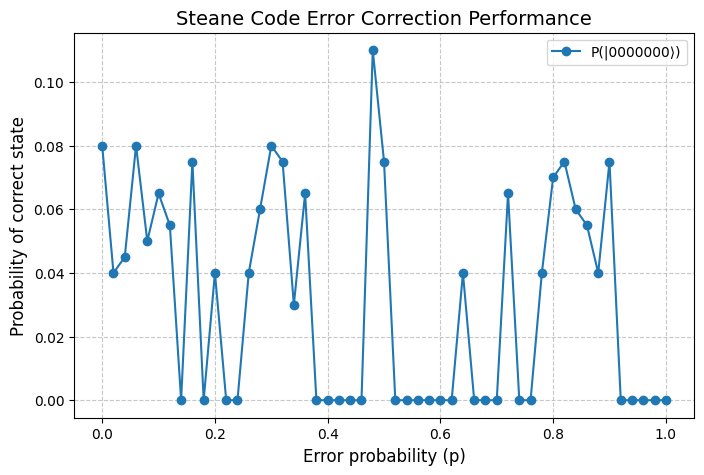

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def simulate_error_correction(p, shots=200):
    """Run the error correction circuit for a given p and return the probability of measuring |0000000⟩."""
    qc, X_syndromes, Z_syndromes, steane = pauli_error_channel(0, p)  # Prepare |0_L⟩
    qcf, steane = checks(qc, X_syndromes, Z_syndromes, steane)

    # Measure the logical qubit
    qubit_measurements = ClassicalRegister(7, name="cl")
    qcf.add_register(qubit_measurements)
    qcf.measure(steane, qubit_measurements)

    # Simulate
    simulator = AerSimulator()
    compiled_circuit = transpile(qcf, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    counts = job.result().get_counts()

    # After getting counts, parse the bitstrings to check only the data qubits
    correct_counts = 0
    total_shots = 0

    for outcome in counts:
        # Split the outcome into data and ancilla parts (adjust indices if needed)
        data_qubits = outcome[:7]  # First 7 bits = data qubits
        ancilla_qubits = outcome[7:]  # Remaining bits = ancillas

        if data_qubits == '0000000':
            correct_counts += counts[outcome]
        total_shots += counts[outcome]

    probability = correct_counts / total_shots

    # Compute the probability of measuring |0000000⟩
    #correct_state = '0000000'
    #correct_counts = counts.get(correct_state,0)
    #probability = correct_counts / shots

    return probability

# Sweep p from 0 to 1
p_values = np.linspace(0, 1, 51)  # 21 points between 0 and 1
probabilities = []

for p in p_values:
    prob = simulate_error_correction(p)
    probabilities.append(prob)
    print(f"p = {p:.2f}, P(|0000000⟩) = {prob:.5f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(p_values, probabilities, 'o-', label='P(|0000000⟩)')
plt.xlabel('Error probability (p)', fontsize=12)
plt.ylabel('Probability of correct state', fontsize=12)
plt.title('Steane Code Error Correction Performance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()